# Adaptive Bandwidth

In [1]:
import numpy as np

from jax import numpy as jnp
from jax import random

import matplotlib.pyplot as plt

import sgGWR

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


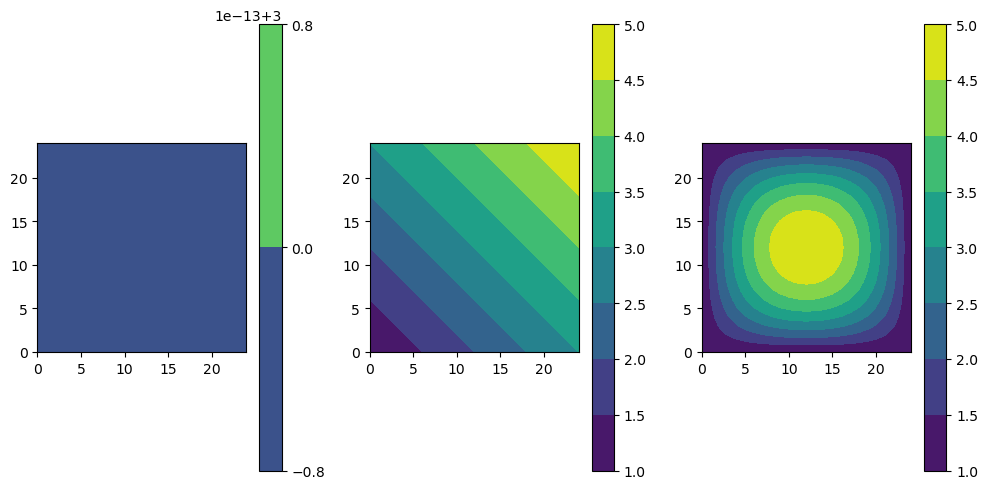

In [3]:
# spatial coefficient from
# Fotheringham, A. S., Yang, W., & Kang, W. (2017). Multiscale Geographically Weighted Regression (MGWR).
# Annals of the American Association of Geographers, 107(6), 1247–1265. https://doi.org/10.1080/24694452.2017.1352480

u0, v0 = jnp.arange(25), jnp.arange(25)
u, v = jnp.meshgrid(u0, v0)
u, v = u.flatten(), v.flatten()
N = len(u)
rngkey = random.PRNGKey(123)

beta = jnp.stack(
    [
        3 * jnp.ones(N),
        1 + (u + v) / 12,
        1 + (36 - jnp.square(6 - u / 2)) * (36 - jnp.square(6 - v / 2)) / 324,
    ]
).T
X = jnp.concatenate([jnp.ones((N, 1)), random.normal(rngkey, shape=(N, 2))], axis=1)
y = jnp.sum(X * beta, axis=1) + 0.5 * random.normal(rngkey, shape=(N,))
# %%
fig, axes = plt.subplots(1, 3, subplot_kw={"aspect": "equal"}, figsize=(10, 5))

for d in range(3):
    ct = axes[d].contourf(u0, v0, beta[:, d].reshape(len(u0), len(v0)))
    fig.colorbar(ct, ax=axes[d])

fig.tight_layout()
plt.show()

In [5]:
sites = jnp.stack([u, v]).T

kernel = sgGWR.kernels.AdaptiveKernel(params=[10])
model_gwr = sgGWR.models.GWR(y, X, sites, kernel=kernel)

optim = sgGWR.optimizers.golden_section()
optim.run(model_gwr)

model_gwr.set_betas_inner()

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

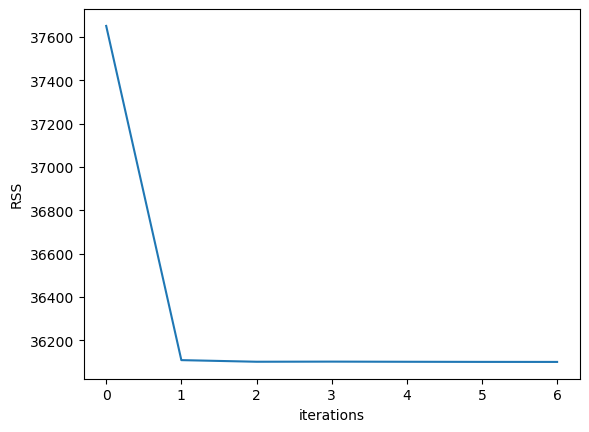

In [9]:
sites = jnp.stack([u, v]).T

kernel = sgGWR.kernels.AdaptiveKernel(params=[10])
model_mgwr = sgGWR.models.MGWR(y, X, sites, kernel=kernel, base_class=sgGWR.models.GWR)

optims = [sgGWR.optimizers.golden_section()] * 3

model_mgwr.backfitting(optimizers=optims, run_params={"verbose": False})

plt.plot(model_mgwr.RSS)
plt.xlabel("iterations")
plt.ylabel("RSS")
plt.show()

In [10]:
print("GWR bandwidth  = ", model_gwr.kernel.params[0])
print("MGWR bandwidth = ", [int(k.params[0]) for k in model_mgwr.kernel])

GWR bandwidth  =  29
MGWR bandwidth =  [161, 35, 26]


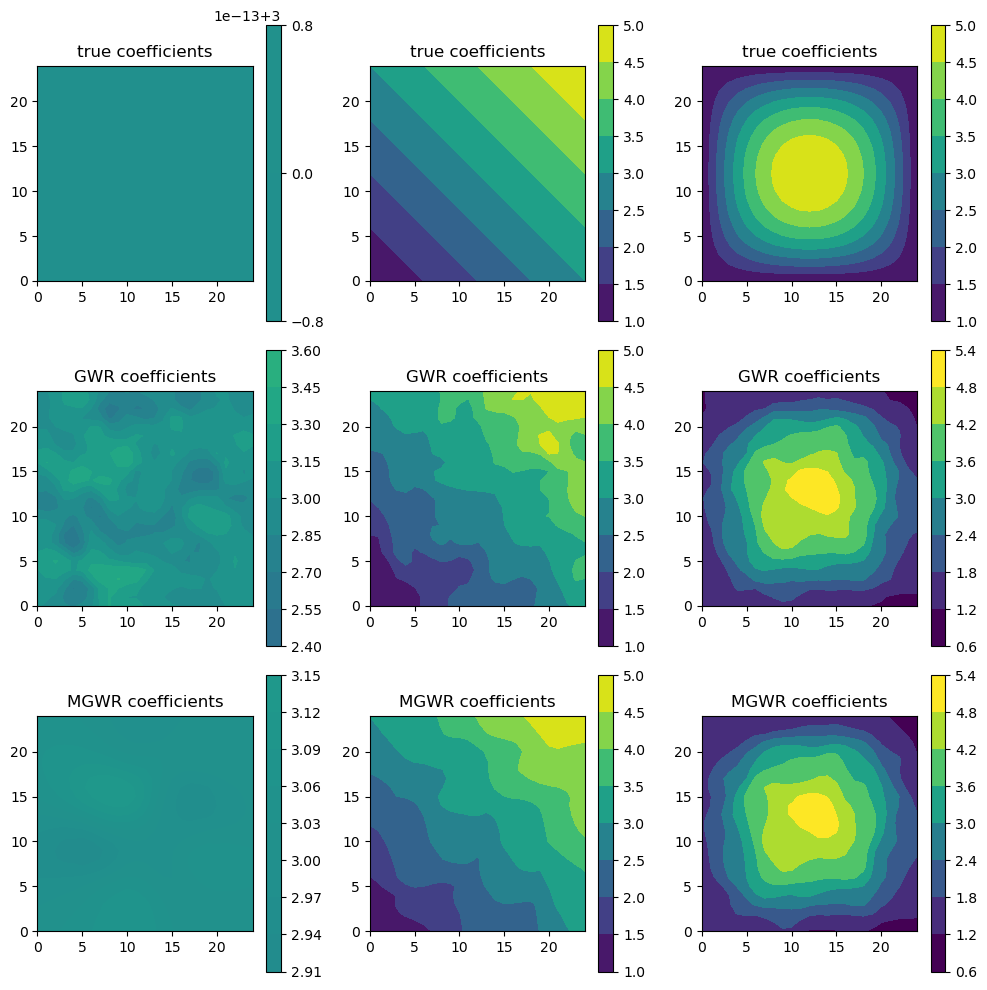

In [11]:
fig, axes = plt.subplots(3, 3, subplot_kw={"aspect": "equal"}, figsize=(10, 10))

for d in range(3):
    axes[0][d].set_title("true coefficients")
    ct = axes[0][d].contourf(
        u0, v0, beta[:, d].reshape(len(u0), len(v0)), vmin=1.0, vmax=5.0
    )
    fig.colorbar(ct, ax=axes[0][d])

    axes[1][d].set_title("GWR coefficients")
    ct = axes[1][d].contourf(
        u0, v0, model_gwr.betas[:, d].reshape(len(u0), len(v0)), vmin=1.0, vmax=5.0
    )
    fig.colorbar(ct, ax=axes[1][d])

    axes[2][d].set_title("MGWR coefficients")
    ct = axes[2][d].contourf(
        u0, v0, model_mgwr.betas[:, d].reshape(len(u0), len(v0)), vmin=1.0, vmax=5.0
    )
    fig.colorbar(ct, ax=axes[2][d])

fig.tight_layout()
plt.show()

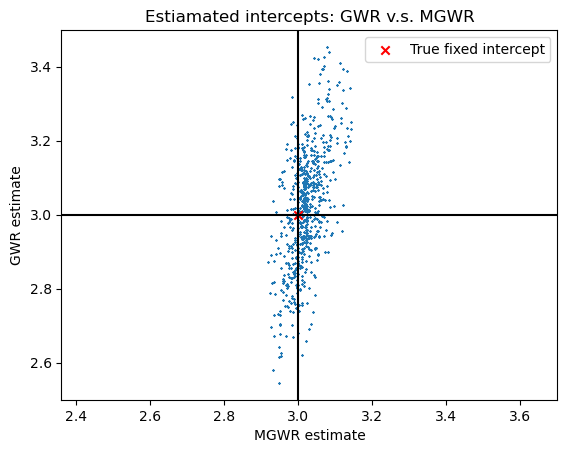

In [12]:
plt.axis("equal")
plt.scatter(model_mgwr.betas[:, 0], model_gwr.betas[:, 0], s=1, marker="x")
plt.axvline(3, color="k")
plt.axhline(3, color="k")
plt.scatter(3, 3, marker="x", c="red", label="True fixed intercept")
plt.legend()
plt.title("Estiamated intercepts: GWR v.s. MGWR")
plt.xlabel("MGWR estimate")
plt.ylabel("GWR estimate")
plt.show()